In [1]:
import utils
import numpy as np
import matplotlib.pyplot as plt
import os
import shutil
import cv2
import albumentations as A
import seaborn as sns
from PIL import Image

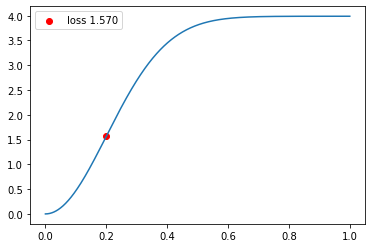

In [2]:
def normal_dist(x , mean , sd):
    prob_density = 1/(sd*np.sqrt(2*np.pi))* np.exp(-0.5*((x-mean)/(2*sd))**2)
    return prob_density

x = np.arange(0, 1, 0.001)
p = 0.2
sd = 0.1
max = 10/(np.sqrt(2*np.pi))
f = max-normal_dist(x,0,sd)
loss = max-normal_dist(p,0,sd)

plt.plot(x,f)
plt.scatter(p,loss, c='r',label="loss {:.3f}".format(loss))
plt.legend()
plt.show()

In [3]:
import torch

a =  torch.tensor([[[1.,1.]],[[11.,11.]],[[1.,1.]],[[1.,1.]]])
b = torch.tensor([[[2.,2.]],[[2.,2.]],[[2.,2.]],[[2.,2.]]])

euc = torch.cdist(a,b)
print(euc)

tensor([[[ 1.4142]],

        [[12.7279]],

        [[ 1.4142]],

        [[ 1.4142]]])


In [4]:
_,train_name = utils.list_files("/zhome/3b/d/154066/repos/GALIROOT/data/l515_lab_1410/img", ".png")
_,test_name = utils.list_files("/zhome/3b/d/154066/repos/GALIROOT/data/l515_lab_1410_test/img", ".png")

d_path, d_name = utils.list_files("/home/bbejczy/repos/GALIROOT/data/l515_imgs/", ".png")

test_out = "/home/bbejczy/repos/GALIROOT/data/l515_lab_1410_test/depth/"
train_out = "/home/bbejczy/repos/GALIROOT/data/l515_lab_1410/depth/"

# def _replace_text(list, oldtext, newtext):
#     newlist = []
#     for name in list:
#         name = name.replace(oldtext,newtext)
#         newlist.append(name)
#     return newlist

# train_d_list = _replace_text(train_name, "rgb", "depth")
# test_d_list = _replace_text(test_name, "rgb", "depth")

# tc, tec = 0,0

# for idx, name in enumerate(d_name):
#     # print(name)
#     if "depth" in name:
#         if name in test_d_list:
#             try: 
#                 shutil.copyfile(d_path[idx],test_out+f"{name}")
#                 tec += 1
#             except shutil.Error:
#                 print(f"{name} already exists")
#                 pass
#         if name in train_d_list:
#             try: 
#                 shutil.copyfile(d_path[idx],train_out+f"{name}")
#                 tc += 1
#             except shutil.Error:
#                 print(f"{name} already exists")
#                 pass

# print(f"train {tc} test {tec}")

In [5]:
train_path_d,train_name_d = utils.list_files("/zhome/3b/d/154066/repos/GALIROOT/data/l515_lab_1410/depth", ".png")
_,test_name_d = utils.list_files("/zhome/3b/d/154066/repos/GALIROOT/data/l515_lab_1410_test/depth", ".png")

In [6]:
i = np.random.randint(0,20)
i2 = np.random.randint(0,111)

print(test_name_d[i])
print(test_name[i])
print(train_name_d[i2])
print(train_name[i2])

20200908_skaevinge_depth_0_1631091819389770508.png
20200908_skaevinge_rgb_0_1631091819389770508.png
20200806_stengard_depth_1_1628244235007698059.png
20200806_stengard_rgb_1_1628244235007698059.png


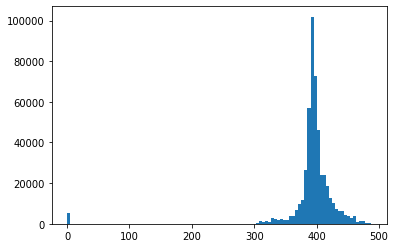

In [7]:
image = cv2.imread(train_path_d[0], cv2.IMREAD_UNCHANGED )
transform = A.Compose([A.Crop(x_min=345,y_min=365,x_max=1120,y_max=1000)])
image = transform(image=image)
image = image['image']
non_zero_image = image[image!=0]
# cv_image_norm = cv2.normalize(non_zero_image, non_zero_image, 0, 1, cv2.NORM_MINMAX)
# print(non_zero_image.min())
plt.hist(image.ravel(),bins=100);

plt.show()


In [8]:
CMAP_DEFAULT = 'plasma'

def gray2rgb(im, cmap=CMAP_DEFAULT):
  cmap = plt.get_cmap(cmap)
  result_img = cmap(im.astype(np.float32))
  if result_img.shape[2] > 3:
    result_img = np.delete(result_img, 3, 2)
  return result_img

def normalize_depth_for_display(depth, pc=95, crop_percent=0, normalizer=None,
                                cmap=CMAP_DEFAULT):
  """Converts a depth map to an RGB image."""
  # Convert to disparity.

  disp = 1.0 / (depth + 1e-6)
  if normalizer is not None:
    disp /= normalizer
  else:
    disp /= (np.percentile(disp, pc) + 1e-6)
  disp = np.clip(disp, 0, 1)
  disp = gray2rgb(disp, cmap=cmap)
  keep_h = int(disp.shape[0] * (1 - crop_percent))
  disp = disp[:keep_h]
  return disp

image = cv2.imread(train_path_d[4], cv2.IMREAD_UNCHANGED )
transform = A.Compose([A.Crop(x_min=345,y_min=365,x_max=1120,y_max=1000)])
image = transform(image=image)
image = image['image']

image = normalize_depth_for_display(image)
cv2.imshow("image",image)
cv2.waitKey(0)
cv2.destroyAllWindows()


In [ ]:
image_pil = np.asarray(Image.open(train_path_d[1]))

transform = A.Compose([A.Crop(x_min=345,y_min=365,x_max=1120,y_max=1000),A.Normalize(mean = [441.6681], std = [37.0956])])

# non_zero_image = image_pil[image_pil!=0]
# print(non_zero_image)
# plt.figure(1)
# plt.hist(non_zero_image.ravel(),bins=100);
# plt.show()
image = transform(image=image_pil)
image = image['image']

# cv2.imshow("image",image)
# cv2.waitKey(0)
# cv2.destroyAllWindows()
# cv_image_norm = cv2.normalize(non_zero_image, non_zero_image, 0, 1, cv2.NORM_MINMAX)
# print(non_zero_image.min())
plt.figure(2)
plt.hist(image.ravel(),bins=100);

plt.show();


